<a href="https://colab.research.google.com/github/SattuSupCodes/SentimentAnalysis_TheoreticalLearning/blob/main/RP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RP Implementation
1. Whisper model
2. ECAPA-TDNN
3. AHC
4. speechbrain/spkrec-ecapa-voxceleb

First will see man-woman conversation diarisation, and then conduct a stress test

In [1]:
!pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 43.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 7.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=b90a1bfa0777759e04bc7a22bd7f12e72e0f509e3bbfc7ae0b69df1f17aa7f3b
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [2]:
!pip install --no-cache-dir \
  "torch==2.0.1+cpu" \
  "torchaudio==2.0.2+cpu" \
  --index-url https://download.pytorch.org/whl/cpu

!pip install "speechbrain==0.5.16" soundfile

Looking in indexes: https://download.pytorch.org/whl/cpu
ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cpu (from versions: 2.2.0+cpu, 2.2.1+cpu, 2.2.2+cpu, 2.3.0+cpu, 2.3.1+cpu, 2.4.0+cpu, 2.4.1+cpu, 2.5.0+cpu, 2.5.1+cpu, 2.6.0+cpu, 2.7.0+cpu, 2.7.1+cpu, 2.8.0+cpu, 2.9.0+cpu, 2.9.1+cpu, 2.10.0+cpu)
ERROR: No matching distribution found for torch==2.0.1+cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.2/788.2 kB 55.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import librosa
import os
import torchaudio
from speechbrain.lobes.models.ECAPA_TDNN import ECAPA_TDNN
from speechbrain.pretrained import EncoderClassifier
import torch
from sklearn.cluster import AgglomerativeClustering
import soundfile as sf
from sklearn.cluster import SpectralClustering

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

ecapa = EncoderClassifier.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    run_opts={"device": device}
)

ecapa.eval()
print("ECAPA loaded (frozen embedding extractor)")

hyperparams.yaml: 0.00B [00:00, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/83.3M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/5.53M [00:00<?, ?B/s]

label_encoder.txt: 0.00B [00:00, ?B/s]

ECAPA loaded (frozen embedding extractor)


In [26]:

wav, sr = sf.read("sample4.wav")

wav = torch.tensor(wav, dtype=torch.float32)

if wav.ndim == 2:   # stereo → mono meaning combining two channels in one because our ecapa can only process mono audios
    wav = wav.mean(dim=1)

print(wav.shape, sr)


torch.Size([4449280]) 44100


In [27]:
if sr != 16000:
    wav = torchaudio.functional.resample(wav, sr, 16000)
    sr = 16000

In [28]:
print("Sample rate:", sr)

Sample rate: 16000


In [29]:
frame_sec = 0.025
frame_len = int(frame_sec * sr)
hop_len = frame_len // 2


In [30]:
energies = []

for i in range(0, len(wav) - frame_len, hop_len):
    frame = wav[i:i+frame_len]
    energy = np.sum(frame.numpy()**2)
    energies.append(energy)

energies = np.array(energies) # energies is loudness indicator-->A VAD system

In [31]:
energy_thresh = 0.03 * np.max(energies)

In [32]:
speech_mask = energies > energy_thresh

In [33]:
segments = []
start = None

for i, is_speech in enumerate(speech_mask):
    t = i * hop_len / sr
    if is_speech and start is None:
        start = t
    elif not is_speech and start is not None:
        end = t
        if end - start > 0.5:  # min speech length
            segments.append((start, end))
        start = None

# handle last segment
if start is not None:
    segments.append((start, len(wav)/sr))


In [34]:
window_sec = 2.5
hop_sec = 1.5

window_samples = int(window_sec * sr)
hop_samples = int(hop_sec * sr)

segments = []

for start in range(0, len(wav) - window_samples, hop_samples):
    segment = wav[start:start + window_samples]
    segments.append(segment)

print(f"Segments created: {len(segments)}")


Segments created: 66


In [35]:
win_len = int(window_sec * sr)
hop_len = int(hop_sec * sr)
embeddings = []

for speech in segments:   # speech is already a waveform tensor

    if len(speech) < win_len:
        continue

    for i in range(0, len(speech) - win_len + 1, hop_len):
        chunk = speech[i:i+win_len]

        with torch.no_grad():
            emb = ecapa.encode_batch(chunk.unsqueeze(0))

        emb = emb.squeeze(0)
        embeddings.append(emb.cpu().numpy())

if len(embeddings) == 0:
    raise RuntimeError("No embeddings extracted — VAD/windowing mismatch")

embeddings = np.vstack(embeddings)
print("Embeddings shape:", embeddings.shape)



Embeddings shape: (66, 192)


 o/p (number of segments, embedding dimensions)-> speaker info in vector form

----ecapa setup done----

In [36]:
import whisper

model = whisper.load_model("base")
result = model.transcribe("sample4.wav")

segments = result["segments"]
for seg in segments:
    print(f"{seg['start']:.2f}-{seg['end']:.2f}: {seg['text']}")


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


0.00-6.60:  I'd love to have you talk to the person who is with us right now.
6.60-11.72:  They've either hit play in this episode and taken us on a walk or you and I are in their
11.72-17.84:  car or at work or in their kitchen as they've got their earbuds in.
17.84-24.64:  And I'd love for you to tell the person listening what might change about their life and their
24.64-28.36:  friendships and how they feel about themselves.
28.36-32.12:  If they take everything that you're about to share with us to heart and they apply it to
32.12-33.12:  their life.
33.12-37.92:  I think that by the time they're done listening or watching it, they feel instantly more
37.92-46.32:  confident, less alone about any secret, private struggles that they're experiencing in their
46.32-47.32:  friendships.
47.32-52.76:  And I'm hoping that it increases their level of optimism about all that is available
52.76-55.00:  to them in friendship.
55.00-59.08:  That's what I'm really hoping for by the time that 

----whisper setup done----

In [37]:
clusterer = AgglomerativeClustering(
    n_clusters=None,
    metric="cosine",
    linkage="average",
    distance_threshold=0.7
)

labels = clusterer.fit_predict(embeddings)
print("Speakers detected:", len(set(labels)))

Speakers detected: 2


In [38]:
prev = labels[0]
print(f"0.00s → Speaker {prev}")

for i in range(1, len(labels)):
    if labels[i] != prev:
        t = i * hop_sec
        print(f"{t:.2f}s → Speaker {labels[i]}")
        prev = labels[i]


0.00s → Speaker 0
33.00s → Speaker 1
58.50s → Speaker 0


In [39]:
np.unique(labels, return_counts=True)


(array([0, 1]), array([49, 17]))

----Agglomerative Clustering setup done----

# Points to note
1. the end result seems to show that from 0.00 s we have started with speaker 0 and then 12s and so on is speaker 1 and after that no change in speakers is shown.
2. Will try working with spectral clustering.

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

S = cosine_similarity(embeddings)

In [41]:
sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    assign_labels="kmeans",
    random_state=42
)

labels_spec = sc.fit_predict(S)

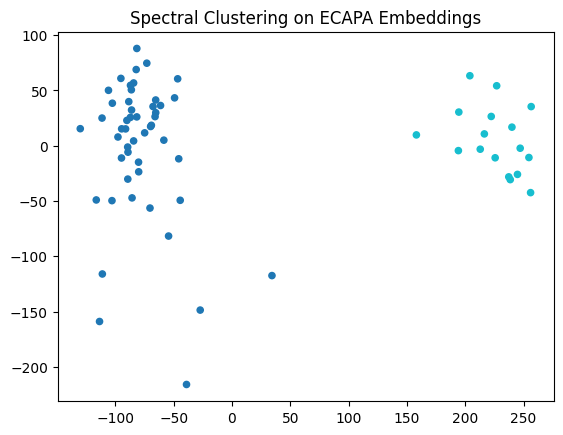

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_2d = PCA(n_components=2).fit_transform(embeddings)

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_spec, cmap="tab10", s=20)
plt.title("Spectral Clustering on ECAPA Embeddings")
plt.show()

by far the best clustering i saw using spectral clustering.